# Expected return and probability densities given by geometric Brownian motion

In [80]:
# Setup for the notebook
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from scipy.stats import norm, lognorm

# plt.style.use('ggplot')
plt.style.use("seaborn-v0_8-whitegrid")
project_root = Path(os.path.abspath(""))

from quantform.pylib import QfDate

In [2]:
# Download full history for $SPY
# %pip install yfinance

# import yfinance as yf

# spy    = yf.Ticker("SPY")
# spy_df = spy.history(period="max")
# spy_df.to_csv(project_root / "example_data" / "SPY_Historical_max.csv")

## Historical SPY distribution

In [3]:
spy_df = pd.read_csv(project_root / "example_data" / "SPY_Historical_max.csv")
spy_df = spy_df.query("Date <= '2025-11-14'")

# Set a datetime index
spy_df = spy_df.set_index(pd.DatetimeIndex(pd.to_datetime(spy_df["Date"])))

In [4]:
# Calculate yearly log-returns
spy_df["Close_lagged"] = spy_df["Close"].shift(periods=252)
spy_df["Log_returns"] = np.log(spy_df["Close"] / spy_df["Close_lagged"])

In [5]:
mean = spy_df.query("Date <= '2025-08-15'")["Log_returns"].mean()
std  = spy_df.query("Date <= '2025-08-15'")["Log_returns"].std()

print(f"Mean: {mean:.5f}")
print(f"STD:  {std:.5f}")

sigma = np.sqrt(std)
mu    = mean + 0.5 * sigma ** 2

print(f"Drift:      {mu:.5f}")
print(f"Volatility: {sigma:.5f}")

Mean: 0.09919
STD:  0.16477
Drift:      0.18158
Volatility: 0.40592


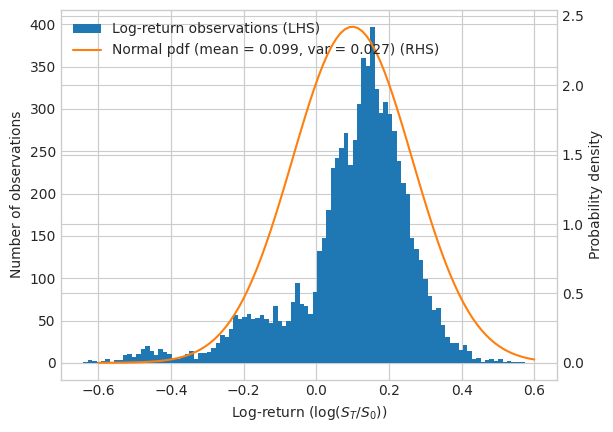

In [6]:
from mpl_toolkits.axes_grid1 import host_subplot

host = host_subplot(111)
par  = host.twinx()

host.set_xlabel(r"Log-return ($\log (S_T / S_0)$)")
host.set_ylabel("Number of observations")
par.set_ylabel("Probability density")

p1 = host.hist(spy_df.query("Date <= '2025-08-15'")["Log_returns"], bins=100, label="Log-return observations (LHS)")
p2 = par.plot(np.linspace(-0.6, 0.6, 100), norm.pdf(np.linspace(-0.6, 0.6, 100), loc=mean, scale=std), label=f"Normal pdf (mean = {mean:.3f}, var = {(std ** 2):.3f}) (RHS)")

host_ylims = host.axes.get_ylim()
host_yratio = host_ylims[0] / host_ylims[1]

par_ylims = par.axes.get_ylim()
par_yratio = par_ylims[0] / par_ylims[1]

if host_yratio < par_yratio: 
    par.set_ylim(bottom = par_ylims[1] * host_yratio)
else:
    host.set_ylim(bottom = host_ylims[1] * par_yratio)
    
host.legend(loc="upper left")

## SPY time-series

In [7]:
dates    = spy_df["Date"].apply(lambda val: val.split(' ')[0]).to_numpy()
qf_dates = [QfDate(int(date.split("-")[0]), int(date.split("-")[1]), int(date.split("-")[2]), calendar = "NYSE", convention = "Business/252") for date in dates]
tt       = [qf_dates[0].timedelta(qf_date) for qf_date in qf_dates]

/tmp/ipykernel_17961/1053623286.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spy_expectations = spy_df.query("Date <= '2025-08-15'")["Close"][0] * np.exp(mean * np.array(tt))
/tmp/ipykernel_17961/1053623286.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spy_stds         = [lognorm.std(s = std * np.sqrt(t), scale = np.exp(np.log(spy_df["Close"][0]) + mean * t)) for t in tt]


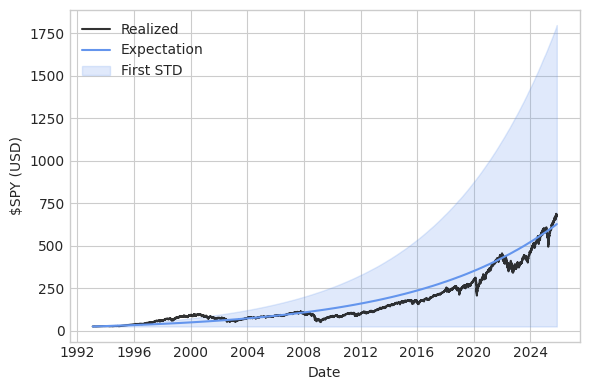

In [47]:
spy_expectations = spy_df.query("Date <= '2025-08-15'")["Close"][0] * np.exp(mean * np.array(tt))
# spy_vars         = spy_df.query("Date <= '2025-08-15'")["Close"][0] * np.exp(sigma ** 2 * np.array(tt))
spy_stds         = [lognorm.std(s = std * np.sqrt(t), scale = np.exp(np.log(spy_df["Close"][0]) + mean * t)) for t in tt]

fig = plt.figure(figsize=(6, 4))

plt.plot(spy_df.index, spy_df["Close"], color="black", label="Realized", alpha=0.8)
plt.plot(spy_df.index, spy_expectations, color="cornflowerblue", label="Expectation")
plt.fill_between(spy_df.index, np.max(spy_expectations - spy_stds, 0), spy_expectations + spy_stds, label="First STD", color="cornflowerblue", alpha=0.2)

plt.ylabel("$SPY (USD)")
plt.xlabel("Date")
plt.legend()

fig.tight_layout()
fig.savefig(project_root / "figures" / "spy_full_time-series.png")
plt.show()

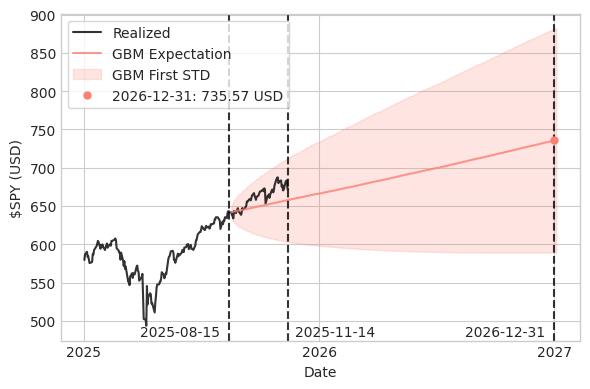

In [86]:
qf_date = QfDate(2025, 8, 15, calendar="NYSE")
qf_future_dates = []

while qf_date <= QfDate(2026, 12, 31, calendar="NYSE"):
  qf_date = qf_date.next_prod_date()
  qf_future_dates.append(qf_date)

tt_250815   = [QfDate(2025, 8, 15, calendar="NYSE").timedelta(qf_date) for qf_date in qf_future_dates]
spy_future_stds         = [lognorm.std(s = std * np.sqrt(t), scale = np.exp(np.log(spy_df["Close"].loc["2025-08-15"]) + mean * t)) for t in tt_250815]
spy_future_expectations = spy_df["Close"].loc["2025-08-15"] * np.exp(mean * np.array(tt_250815))

fig, ax = plt.subplots(figsize=(6, 4))

plt.plot(spy_df.query("Date >= '2025-01-01'").index, spy_df.query("Date >= '2025-01-01'")["Close"], color="black", label="Realized", alpha=0.8)
plt.plot(qf_future_dates, spy_future_expectations, color="salmon", label="GBM Expectation", alpha=0.8)
plt.fill_between(qf_future_dates, spy_future_expectations - spy_future_stds, spy_future_expectations + spy_future_stds, label="GBM First STD", color="salmon", alpha=0.2)

plt.axvline(pd.to_datetime("2025-08-15"), color='black', linestyle='dashed', alpha=0.8)
ax.text(pd.to_datetime("2025-03-30"), 480, "2025-08-15", fontsize=10)

plt.axvline(pd.to_datetime("2025-11-14"), color='black', linestyle='dashed', alpha=0.8)
ax.text(pd.to_datetime("2025-11-25"), 480, "2025-11-14", fontsize=10)

plt.axvline(pd.to_datetime("2026-12-31"), color='black', linestyle='dashed', alpha=0.8)
ax.text(pd.to_datetime("2026-08-15"), 480, "2026-12-31", fontsize=10)

plt.plot([pd.to_datetime("2026-12-31")], [spy_future_expectations[-1]], color="salmon", linestyle='None', marker='o', markersize=5, label=f"2026-12-31: {spy_future_expectations[-1]:.2f} USD")

plt.ylabel("$SPY (USD)")
plt.xlabel("Date")
years = mdates.YearLocator()
ax.xaxis.set_major_locator(years)
# plt.xticks(rotation=30)
plt.legend(frameon=True, fancybox=True)

fig.tight_layout()
fig.savefig(project_root / "figures" / "gbm_time-series.png")
plt.show()

## SPY Distributions

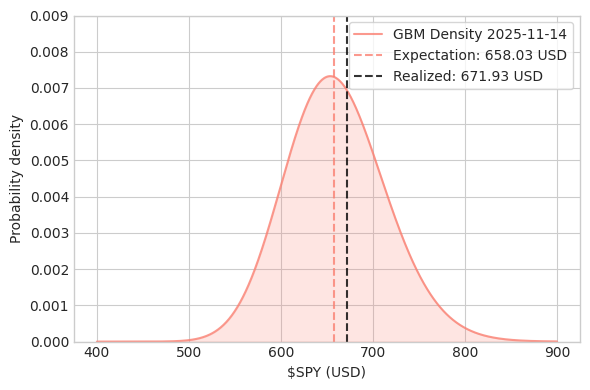

In [85]:
fig, ax = plt.subplots(figsize = (6, 4))

t_251114     = QfDate(2025, 8, 15, calendar="NYSE").timedelta(QfDate(2025, 11, 14, calendar="NYSE"))
exp_t_251114 = spy_df["Close"].loc["2025-08-15"] * np.exp(mean * np.array(t_251114))

xx_251114 = np.linspace(400, 900, 1000)
yy_251114 = lognorm.pdf(xx_251114, s = std * np.sqrt(t_251114), scale = np.exp(np.log(spy_df["Close"].loc["2025-08-15"]) + mean * t_251114))

plt.plot(xx_251114, yy_251114, color="salmon", alpha=0.8, label="GBM Density 2025-11-14")
ax.fill_between(xx_251114, [0] * len(xx_251114), yy_251114, color="salmon", alpha=0.2)
plt.axvline(exp_t_251114, color="salmon", alpha=0.8, linestyle="dashed", label=f"Expectation: {exp_t_251114:.2f} USD") 
plt.axvline(671.93, color='black', linestyle='dashed', alpha=0.8, label=f"Realized: 671.93 USD")

plt.xlabel(f"$SPY (USD)")
plt.ylabel(f"Probability density")
plt.legend(frameon=True, fancybox=True)

plt.ylim(0, 0.009)

fig.tight_layout()
fig.savefig(project_root / "figures" / "gbm_density_2025-11-14.png")
plt.show()

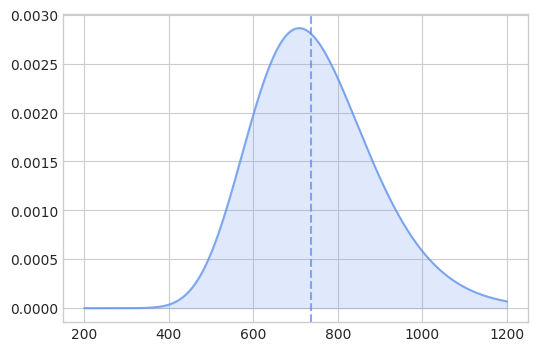

In [43]:
fig, ax = plt.subplots(figsize = (6, 4))

t_261231     = QfDate(2025, 8, 15, calendar="NYSE").timedelta(QfDate(2026, 12, 31, calendar="NYSE"))
exp_t_261231 = spy_df["Close"].loc["2025-08-15"] * np.exp(mean * np.array(t_261231))

xx_261231 = np.linspace(200, 1200, 1000)
yy_261231 = lognorm.pdf(xx_261231, s=std * np.sqrt(t_261231), scale=np.exp(np.log(spy_df["Close"].loc["2025-08-15"]) + mean * t_261231))

plt.plot(xx_261231, yy_261231, color="cornflowerblue", alpha=0.8)
ax.fill_between(xx_261231, [0] * len(xx_261231), yy_261231, color="cornflowerblue", alpha=0.2)
plt.axvline(exp_t_261231, color="cornflowerblue", alpha=0.8, linestyle="dashed") 
